## 寻找配对
- 根据累积收益率最小距离筛选pairs

In [1]:
import pickle
from itertools import combinations
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data/preprocessed.csv")
with open("data/cumReturn.bin", "rb") as f:
    returns = pickle.load(f)

In [3]:
data.head()

,date,asset,close,volume
0,2017-01-03,LLDPE,9710.0,415780.0
1,2017-01-03,PTA,5446.0,2106438.0
2,2017-01-03,动力煤,493.0,102390.0
3,2017-01-03,天然橡胶,18360.0,352158.0
4,2017-01-03,棉花,15085.0,184116.0


In [4]:
assets = returns.keys()

In [5]:
def calSSD(x1, x2):
    '''
    @Description
    计算两个序列的距离，返回square sum of deviation
    ------------
    @Params
    x1, x2, Series
    ------------
    @Returns
    ssd, float
    '''
    return np.sum((x1-x2)**2)

In [6]:
def normalize(x):
    '''
    @Description
    min-max归一
    ------------
    @Params
    x, Series
    ------------
    @Returns
    x1, Series
    '''
    return (x-x.min())/(x.max()-x.min())

In [7]:
# 指定形成期12个月
dates = data["date"].unique()
print(len(dates))

1075


In [8]:
dates

array(['2017-01-03', '2017-01-04', '2017-01-05', ..., '2021-06-02',
       '2021-06-03', '2021-06-04'], dtype=object)

In [14]:
form_days = sum(dates<="2018-01-03")

In [15]:
form_days

246

In [36]:
end_date = sum(dates<="2018-07-03")

In [37]:
end_date

365

In [16]:
# 两两组合计算SSD
SSDs = {}
for asset1, asset2 in combinations(assets, 2):
    # 去除第一个NaN后，应该是[0:form_days-1]
    return1 = normalize(returns[asset1].dropna().values[:form_days-1])
    return2 = normalize(returns[asset2].dropna().values[:form_days-1])
    SSDs[f"{asset1}-{asset2}"] = calSSD(return1, return2)

In [17]:
min(SSDs,key=SSDs.get)

'热轧卷板-螺纹钢'

In [18]:
SSDs["热轧卷板-螺纹钢"]

2.106076461737342

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
zhfont = FontProperties(fname="/System/Library/Fonts/PingFang.ttc")

In [20]:
# 形成期
data[data["asset"]=="热轧卷板"].iloc[:form_days,:]

,date,asset,close,volume
6,2017-01-03,热轧卷板,3298.0,251094.0
41,2017-01-04,热轧卷板,3370.0,359388.0
76,2017-01-05,热轧卷板,3358.0,305690.0
111,2017-01-06,热轧卷板,3273.0,427108.0
146,2017-01-09,热轧卷板,3449.0,361934.0
...,...,...,...,...
8441,2017-12-27,热轧卷板,3857.0,681648.0
8476,2017-12-28,热轧卷板,3848.0,617426.0
8511,2017-12-29,热轧卷板,3846.0,772990.0
8546,2018-01-02,热轧卷板,3927.0,570750.0


In [38]:
# 交易期
data[data["asset"]=="热轧卷板"].iloc[form_days:end_date,:]

,date,asset,close,volume
8616,2018-01-04,热轧卷板,3877.0,568448.0
8651,2018-01-05,热轧卷板,3842.0,869870.0
8686,2018-01-08,热轧卷板,3864.0,769662.0
8721,2018-01-09,热轧卷板,3862.0,595800.0
8756,2018-01-10,热轧卷板,3880.0,696268.0
...,...,...,...,...
12606,2018-06-27,热轧卷板,3831.0,545784.0
12641,2018-06-28,热轧卷板,3875.0,570942.0
12676,2018-06-29,热轧卷板,3926.0,465094.0
12711,2018-07-02,热轧卷板,3861.0,562860.0


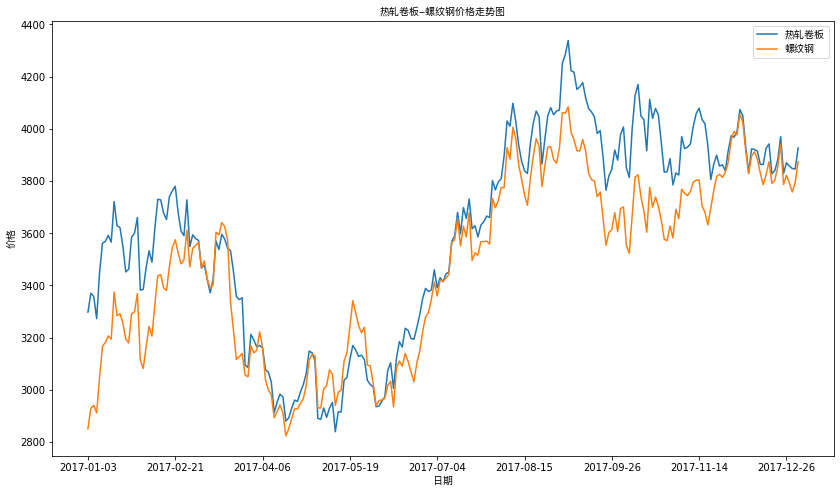

In [47]:
fig, ax = plt.subplots(figsize=(14, 8))
d1 = data[data["asset"]=="热轧卷板"].iloc[:245,:]
d2 = data[data["asset"]=="螺纹钢"].iloc[:245, :]
ax.plot(d1.date, d1.close, label=u"热轧卷板")
ax.plot(d2.date, d2.close, label=u"螺纹钢")
# plt.tight_layout()
ax.legend(prop=zhfont)
ax.set_xlabel(u"日期", fontproperties=zhfont)
ax.set_ylabel(u"价格", fontproperties=zhfont)
ax.set_title(u"热轧卷板-螺纹钢价格走势图", fontproperties=zhfont)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.show()

In [25]:
# fig, ax = plt.subplots(figsize=(16, 10))
# d1 = data[data["asset"]=="热轧卷板"].iloc[:245,:]
# d2 = data[data["asset"]=="螺纹钢"].iloc[:245, :]
# ax.plot(d1.date, d1.close.values-d2.close.values)
# ax.set_xlabel(u"日期", fontproperties=zhfont)
# ax.set_ylabel(u"价格", fontproperties=zhfont)
# ax.set_title(u"热轧卷板-螺纹钢价差图", fontproperties=zhfont)
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
# plt.show()

In [42]:
# 按SSD大小排序
SSDs = sorted(SSDs.items(), key=lambda d:d[1])

In [44]:
with open("data/SSDs.bin", "wb") as f:
    pickle.dump(SSDs, f)

In [45]:
# test 
with open("data/SSDs.bin", "rb") as f:
    SSDs = pickle.load(f)

In [46]:
SSDs

[('热轧卷板-螺纹钢', 2.106076461737342),
 ('棕榈油-豆油', 2.3065572850156535),
 ('天然橡胶-铁矿石', 3.5802903906067987),
 ('PTA-甲醇', 3.604143680557888),
 ('玉米-玉米淀粉', 3.8393225765306016),
 ('LLDPE-聚丙烯', 3.8504522165173567),
 ('天然橡胶-豆油', 3.9567791758309774),
 ('甲醇-聚丙烯', 4.019890953353913),
 ('热轧卷板-铅', 4.084704211210985),
 ('LLDPE-菜籽油', 4.174816576919031),
 ('热轧卷板-锌', 4.379387064649557),
 ('铜-锌', 4.484192755764458),
 ('焦炭-焦煤', 4.574634160092575),
 ('铜-镍', 5.1904982406184015),
 ('螺纹钢-锌', 5.322840409257758),
 ('LLDPE-PTA', 5.342456083173719),
 ('焦炭-聚氯乙烯', 5.34740566309231),
 ('白糖-白银', 5.400612308609993),
 ('热轧卷板-聚丙烯', 5.490938750547963),
 ('甲醇-镍', 5.644959340604445),
 ('LLDPE-甲醇', 5.673945746436101),
 ('硅铁-锰硅', 5.712656589343416),
 ('菜籽粕-豆粕', 5.734471481511491),
 ('豆油-黄大豆1号', 6.395260451121094),
 ('聚丙烯-镍', 6.401556920401594),
 ('玻璃-螺纹钢', 6.534479717813081),
 ('天然橡胶-棕榈油', 6.580629484559277),
 ('铝-锌', 6.836987241425023),
 ('聚丙烯-铅', 6.918388282397423),
 ('热轧卷板-铜', 7.021493838844494),
 ('铅-锌', 7.026125950965931),